# Building an Expected Goals Model for Shot-Event Data

By Jayanth Nair, A Springboard Capstone Project

***Introduction***

The following table contains statistics from a very famous (or rather infamous) game of football, obtained from Christoph Biermann's book Football Hackers. It describes the game with conventional statistical metrics. 

|                             | Team A | Team B |
|-----------------------------|:------:|:------:|
|          Possession         |   52%  |   48%  |
| Passes into the 18 yard box |   19   |   11   |
|           Crosses           |   22   |   10   |
|           Corners           |    7   |    5   |
|      Dangerous attacks      |   55   |   34   |
|         Tackles won         |    5   |    1   |
|          Lost balls         |   69   |   76   |
|            Shots            |   18   |   14   |
|       Shots on Target       |   13   |   12   |

Upon first look, most people would conclude that Team A ran out comfortable winners. However, in reality Team B were the winners by some margin. These statistics are from the 2014 World Cup semi-final between Brazil and Germany. Team B were Germany. They won by 7 goals to 1.

Following the footsteps of baseball (Moneyball and more recently, Astroball) and basketball (Daryl Morey and the Houston Rockets), football/soccer is now undergoing a 'statistical revolution'. New statistical metrics are being developed which can quantify game scenarios better, thereby refining game tactics and player recruitment.

***What is Expected Goals?***

One of the relatively ubiquitous 'new' statistical metrics is Expected Goals (xG). xG essentially quantifies the quality of a shot by the probability of that shot being a goal. Intuitively, we know that a shot taken from outside the box is much less likely to be a goal than one being taken near the goal line. xG is a mere quantification of this intuitiveness. Some examples are below:

![Pavard Goal](https://media.giphy.com/media/jaJkRgaIT6wLayz5V7/giphy.gif)

This belter from Benjamin Pavard in the 2018 World Cup from outside the box will have a lower xG, while the goal below by Barcelona will have a much higher xG

![Barcelona Goal](https://media.giphy.com/media/zRqwfjscelwlO/giphy.gif)

***Why do we need xG?***

xG is an excellent predictor of how good a team is going forward, i.e attacking. The following is a snippet of the Premier League table on Nov 11, 2019 in descending order of points from Understat. (G is Goals scored and xG is, well, xG).

As you can see, the xG numbers match pretty well with the actual goals scored for each team, with some notable exceptions. Leicester City's attackers are ruthless in front of goal, outperforming their xG numbers significantly. Watford, Southampton and Manchester United on the other end seem to be underperforming as per their xG. 

![xGtable](https://i.imgur.com/LYwQilo.png)

Similary expected goals against or xGA can be used to quantify the quality of shots a team faces.  This can be used as an indicator of how good a team's defense is. Below is a table of goals allowed and xGA. At the top end of the table, Leicester and Sheffield United (!!!) seem to be outperforming their xGA numbers while Chelsea seem to be struggling.  The bottom three are all struggling with their defenses leaking goals. 

Both Watford and Southampton were at the receiving end of 0-6 and 0-9 maulings this season, so that will skew their numbers a little.

![xGatable](https://i.imgur.com/PWp0wQn.png)

***Objective***

My objective with this project is to create my own xG model. The dataset I am using is the [Statsbomb open dataset](https://github.com/statsbomb/open-data). Specifically, I will be using the women's soccer dataset which contains data from 2 seasons of the FA WSL, 1 season of NWSL and the 2018 women's world cup

The data contains 229 games and 5929 shots which should be sufficient to build a workable xG model

The approach will be hypothesis-driven. In any hypothesis driven approach, there needs to be a hypothesis tree which drives the data wrangling and exploration.  The hypothesis tree for this project is given below:

![decision_tree](https://imgur.com/wrmwByq.png)

### Data Storytelling

Based on the above decision tree, let's start exploring the data. 

### Step 1 - Importing Necessary Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = 15

### Step 2 - Reading the pickled dataframe 

In [4]:
df = pd.read_pickle('./wrangled_dataframe.pkl')
df.head()

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,timestamp,...,key_pass_type,key_pass_pattern,isCross,isCutback,preceding_event_player,preceding_event_team,statsbomb_xg
0,86.7,57.4,37.6,39.583456,35.894986,10.8,2019-12-06 00:04:36.133,...,None,None,False,False,Taylor Hinds,Everton LFC,0.013571
1,93.9,34.5,26.7,26.143068,27.775169,16.7,2019-12-06 00:04:40.569,...,None,None,False,False,Inessa Kaagman,Everton LFC,0.049914
2,95.8,47.1,25.2,26.624237,24.397746,17.3,2019-12-06 00:05:52.550,...,None,None,False,False,Abbey-Leigh Stringer,Birmingham City WFC,0.022202
3,109.6,54.5,17.8,21.222865,14.778701,15.4,2019-12-06 00:07:03.244,...,Ground Pass,From Throw In,False,False,Inessa Kaagman,Everton LFC,0.078857
4,95.0,44.8,25.5,26.503585,25.012797,17.6,2019-12-06 00:08:15.644,...,None,None,False,False,Hayley Ladd,Birmingham City WFC,0.031914


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 5928
Data columns (total 27 columns):
shot_x                    5918 non-null float64
shot_y                    5918 non-null float64
shot_distance             5918 non-null float64
shot_a                    5918 non-null float64
shot_b                    5918 non-null float64
shot_angle                5918 non-null float64
timestamp                 5918 non-null datetime64[ns]
outcome_name              5918 non-null object
outcome_id                5918 non-null int64
body_part_name            5918 non-null object
body_part_id              5918 non-null int64
technique_name            5918 non-null object
technique_id              5918 non-null int64
type_name                 5918 non-null object
type_id                   5918 non-null int64
first_time                5918 non-null bool
preceding_event           5918 non-null object
pack_density              5918 non-null int64
shot_player               5918 non-null 

In [6]:
df.describe()

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,outcome_id,body_part_id,technique_id,type_id,pack_density,statsbomb_xg
count,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000,5918.000000
mean,103.867033,40.215985,18.883525,19.338181,19.248281,26.639929,98.219162,39.016053,92.944745,86.251267,1.982258,0.098045
std,9.084062,9.832112,9.099585,9.124490,9.125212,17.901006,2.134910,1.809663,0.770081,4.297996,1.394061,0.137525
min,58.000000,5.000000,1.000000,1.019804,1.000000,0.000000,96.000000,37.000000,89.000000,61.000000,0.000000,0.001712
25%,97.525000,33.200000,11.500000,12.041595,12.111145,14.900000,97.000000,38.000000,93.000000,87.000000,1.000000,0.023362
50%,105.600000,40.000000,17.700000,18.365319,18.027756,20.200000,98.000000,40.000000,93.000000,87.000000,2.000000,0.044403
75%,111.000000,47.000000,25.500000,25.961654,25.709920,33.575000,100.000000,40.000000,93.000000,87.000000,2.000000,0.104874
max,120.000000,79.500000,69.200000,71.562350,67.013208,151.900000,116.000000,70.000000,95.000000,88.000000,11.000000,0.937590


### Step 3 - Initial Visual Exploratory Analysis

Before we dissect the decision tree, let's plot all the shot locations on to a pitch

The following code creates the football pitch (courtesy: [PythonFC](https://fcpython.com/visualisation/drawing-pitchmap-adding-lines-circles-matplotlib))

In [9]:
from matplotlib.patches import Arc

In [10]:
# plotting shots on to a pitch

def pitch_creator():
    fig = plt.figure()
    plt.axis([60, 125, -10, 90])
    plt.grid(False)


    plt.plot([60, 60], [0, 80], color='black')
    plt.plot([120, 120], [0, 80], color="black")
    plt.plot([60, 120], [0, 0], color='black')
    plt.plot([60, 120], [80, 80], color='black')

    centreCircle = plt.Circle((60, 40), 10, color='black', fill=False)

    # right penalty area
    plt.plot([120, 102], [18, 18], color='black')
    plt.plot([102, 102], [18, 62], color='black')
    plt.plot([102, 120], [62, 62], color='black')

    # right six yard box
    plt.plot([120, 114], [30, 30], color='black')
    plt.plot([114, 114], [30, 50], color='black')
    plt.plot([114, 120], [50, 50], color='black')


    # right goal posts
    plt.plot([120, 122], [36, 36], color='black')
    plt.plot([120, 122], [44, 44], color='black')
    plt.plot([122, 122], [36, 44], color='black')


    # right Arc
    rightArc = Arc((108, 40), height=18.3, width=18.3, angle=0,
                   theta1=130, theta2=230, color='red')

    ax = plt.gca()
    ax.add_patch(centreCircle)
    ax.add_patch(rightArc)
    ax.set_ylim(ax.get_ylim()[::-1])
    return fig

def plotter(fig,loc_list,color,label):
    
    loc_x=[]
    loc_y=[]
    for loc in loc_list:
        loc_x.append(loc[0])
        loc_y.append(loc[1])
            
    plt.scatter(loc_x,loc_y,c=color,alpha='0.6',label=label,edgecolor='black',linewidth=0.5)
    plt.axis('off')
    
    
    return fig

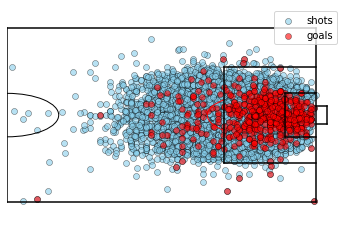

In [12]:
#plotting all data
plt1 = pitch_creator()
plt1 = plotter(plt,df[['shot_x','shot_y']].values,'skyblue','shots')
plt1 = plotter(plt,df[df['outcome_name']=='Goal'][['shot_x','shot_y']].values,'red','goals')
plt.legend(loc='upper right')
plt.show()

Visually we can see that most goals result from shots closer to the goal and located more centrally within the pitch with the exception of outliers

To make it easier to discern goals from shots which don't result in goals for plotting and other calculations, let's add two more columns to the dataframe - isGoal and isGoalBool

In [13]:
isGoal=[]
isGoalBool = []
for outcome in df['outcome_name'].values:
    if outcome=='Goal':
        isGoal.append('Goal')
        isGoalBool.append(True)
    else:
        isGoal.append('Not Goal')
        isGoalBool.append(False)

In [14]:
df['isGoal']=isGoal
df['isGoalBool']=isGoalBool

### Step 5 - EDA Using the Proposed Hypothesis Tree

First, let's look at open play shot types

In [15]:
#isolation open play shots
df_open_play = df[df['type_name']=='Open Play']
df_open_play.head()

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,timestamp,...,isCross,isCutback,preceding_event_player,preceding_event_team,statsbomb_xg,isGoal,isGoalBool
0,86.7,57.4,37.6,39.583456,35.894986,10.8,2019-12-06 00:04:36.133,...,False,False,Taylor Hinds,Everton LFC,0.013571,Not Goal,False
1,93.9,34.5,26.7,26.143068,27.775169,16.7,2019-12-06 00:04:40.569,...,False,False,Inessa Kaagman,Everton LFC,0.049914,Not Goal,False
2,95.8,47.1,25.2,26.624237,24.397746,17.3,2019-12-06 00:05:52.550,...,False,False,Abbey-Leigh Stringer,Birmingham City WFC,0.022202,Not Goal,False
3,109.6,54.5,17.8,21.222865,14.778701,15.4,2019-12-06 00:07:03.244,...,False,False,Inessa Kaagman,Everton LFC,0.078857,Goal,True
4,95.0,44.8,25.5,26.503585,25.012797,17.6,2019-12-06 00:08:15.644,...,False,False,Hayley Ladd,Birmingham City WFC,0.031914,Goal,True


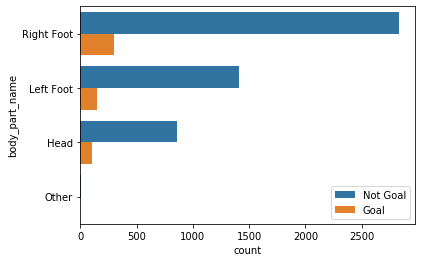

In [16]:
ax=sns.countplot(y='body_part_name',order=['Right Foot','Left Foot','Head','Other'],hue='isGoal',data=df_open_play);
plt.legend(loc='lower right');

The figure above shows that in sheer volumes, the amount of footed shots and goals are higher than headed shots and goals. Let's dig into this a little deeper..

In [17]:
#isolating footed and headed shots and goals

filt1 = (df_open_play['body_part_name']=='Right Foot') | (df_open_play['body_part_name']=='Left Foot')
#calculating number of shots
footed_shots_count = df_open_play[filt1].shape[0] 

#isolating footed goals
footed_goals_count = sum(df_open_play[filt1]['isGoalBool'])

#isolating headed shots
filt2 = (df_open_play['body_part_name']=='Head')
headed_shots_count = df_open_play[filt2].shape[0]

#isolating headed goals
headed_goals_count = sum(df_open_play[filt2]['isGoalBool'])

footed_pct = footed_goals_count/footed_shots_count
headed_pct = headed_goals_count/headed_shots_count

print('The percentage of footed shots which are goals is {0}'.format(round(footed_pct,2)*100))
print('The percentage of headed shots which are goals is {0}'.format(round(headed_pct,2)*100))

The percentage of footed shots which are goals is 10.0
The percentage of headed shots which are goals is 11.0


This is interesting. I expected headers to be less likely to be converted into goals in my decision tree. So let's dig deeper!
Usually, headers are taken from closer to the goal (think corners or crosses into the box). Let's check if the data reflects this

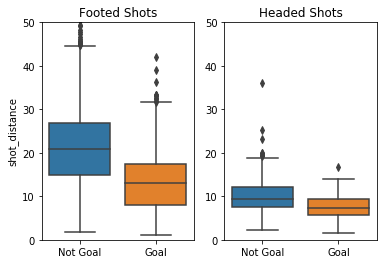

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2=fig.add_subplot(122)
sns.boxplot(x='isGoal',y='shot_distance',data=df_open_play[filt1],ax=ax1)
sns.boxplot(x='isGoal',y='shot_distance',data=df_open_play[filt2],ax=ax2)
ax1.set(ylim=(0,50));
ax2.set(ylim=(0,50));
ax2.set_ylabel('');
ax1.set_xlabel('');
ax2.set_xlabel('');
ax1.set_title('Footed Shots');
ax2.set_title('Headed Shots');

The box plots show that more footed shots are taken from farther distances. Headed shots are almost always taken within the penalty area. This skews the percentage comparison in favor of headed shots. 

For a fair comparison, headed and footed shots within the penalty area must be compared against each other

In [20]:
#filtering out footed shots taken a distance less than 18 yards
filt3 = df_open_play[filt1]['shot_distance']<18
footed_pb_shots_count = df_open_play[filt1][filt3].shape[0]
footed_pb_goals_count = sum(df_open_play[filt1][filt3]['isGoalBool'])

footed_pb_pct = footed_pb_goals_count*100/footed_pb_shots_count

#filtering out headed shots taken a distance less than 18 yards
filt4 = df_open_play[filt2]['shot_distance']<18
headed_pb_shots_count = df_open_play[filt2][filt4].shape[0]
headed_pb_goals_count = sum(df_open_play[filt2][filt4]['isGoalBool'])


headed_pb_pct = headed_pb_goals_count*100/headed_pb_shots_count

print('The goal percentage of footed shots at a distance less than 18 yards is {0}'.format(round(footed_pb_pct,1)))
print('The goal percentage of headed shots at a distance less than 18 yards is {0}'.format(round(headed_pb_pct,1)))

The goal percentage of footed shots at a distance less than 18 yards is 17.3
The goal percentage of headed shots at a distance less than 18 yards is 10.9


As seen above, footed shots are more effective than headed shots, when corrected for distance from goal. Therefore, footed shots should have a higher xG than headers.

Since we are on the topic of headers and footed shots, let's explore what the percentages are for non open play shots. The below code reproduces the above analysis for non open play shots

In [21]:
filt=df['type_name']=='Open Play'
df_not_open_play = df[~filt]

In [22]:
filt1 = (df_not_open_play['body_part_name']=='Right Foot') | (df_not_open_play['body_part_name']=='Left Foot')
filt2 = (df_not_open_play['body_part_name']=='Head')
filt3 = df_not_open_play[filt1]['shot_distance']<18
filt4 = df_not_open_play[filt2]['shot_distance']<18


footed_pb_shots_count = df_not_open_play[filt1][filt3].shape[0]
footed_pb_goals_count = sum(df_not_open_play[filt1][filt3]['isGoalBool'])

footed_pb_pct = footed_pb_goals_count*100/footed_pb_shots_count

headed_pb_shots_count = df_not_open_play[filt2][filt4].shape[0]
headed_pb_goals_count = sum(df_not_open_play[filt2][filt4]['isGoalBool'])

headed_pb_pct = headed_pb_goals_count*100/headed_pb_shots_count

print('The goal percentage of footed shots from non open play at a distance less than 18 yards is {0}'.format(round(footed_pb_pct,1)))
print('The goal percentage of headed shots from non open play at a distance less than 18 yards is {0}'.format(round(headed_pb_pct,1)))

ZeroDivisionError: division by zero

Interestingly, this gives us a zero division error when trying to calculate headed_pb_pct. This is because any headed shot taken as part of a freekick or corner routine in this data set is considered as open play since you can't directly head a ball during a freekick. It has to have a preceding pass. The freekick itself cannot be a header.

We will explore preceding passes and pass play patterns next

As explained in the data wrangling phase, not all shots have a preceding pass.

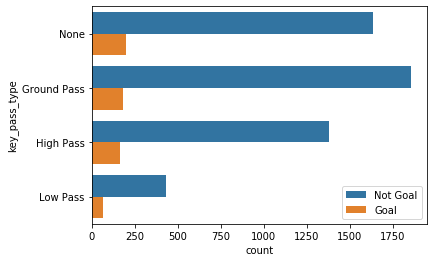

In [23]:
ax=sns.countplot(y='key_pass_type',hue='isGoal',data=df);
plt.legend(loc='lower right');

Most shots do have a preceding pass in the dataset.  The most common type is a 'ground pass' followed by 'high pass' and 'low pass'.  A 'low pass' is defined by Statsbomb as a pass where the ball comes off the ground but is under the shoulder level at peak height. A 'high pass' goes above the shoulder level while during a 'ground pass' the ball doesn't come off the ground

Our hypothesis tree includes checking whether the height of a pass affects the chance of the resulting shot in becoming a goal. Ignoring all other factors, let's look at shot conversions following key passes

In [24]:
def quant_pct(df,column,value):
    filt1 = df[column]==value
    df_filt = df[filt1]
    value_count = df_filt.shape[0]
    goal_count = sum(df_filt['isGoalBool'])
    value_pct = goal_count/value_count
    return value_pct

In [25]:
low_pass_pct = quant_pct(df,'key_pass_type','Low Pass')
high_pass_pct = quant_pct(df,'key_pass_type','High Pass')
ground_pass_pct = quant_pct(df,'key_pass_type','Ground Pass')

print('The percentage of shots from low passes which are goals is {0}'.format(round(low_pass_pct,2)*100))
print('The percentage of shots from high passes which are goals is {0}'.format(round(high_pass_pct,2)*100))
print('The percentage of shots from ground passes which are goals is {0}'.format(round(ground_pass_pct,2)*100))

The percentage of shots from low passes which are goals is 13.0
The percentage of shots from high passes which are goals is 11.0
The percentage of shots from ground passes which are goals is 9.0


Although the least amount of shots result from low passes, it is better than high passes and ground passes. Therefore, without any additional context, aerial passes appear better from a shot scoring perspective

Let's dig a little deeper and check the distances at which shots are taken following these passes

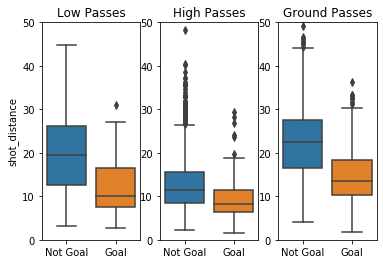

In [28]:
filt1 = df['key_pass_type']=='Low Pass'
filt2 = df['key_pass_type']=='High Pass'
filt3 = df['key_pass_type']=='Ground Pass'
low_pass = df[filt1]
high_pass = df[filt2]
ground_pass = df[filt3]

low_pass=low_pass.sort_values(by='isGoal',ascending=False)
high_pass=high_pass.sort_values(by='isGoal',ascending=False)
ground_pass=ground_pass.sort_values(by='isGoal',ascending=False)

fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.boxplot(x='isGoal',y='shot_distance',data=low_pass,ax=ax1)
sns.boxplot(x='isGoal',y='shot_distance',data=high_pass,ax=ax2)
sns.boxplot(x='isGoal',y='shot_distance',data=ground_pass,ax=ax3)
ax1.set(ylim=(0,50));
ax2.set(ylim=(0,50));
ax3.set(ylim=(0,50));
ax2.set_ylabel('');
ax3.set_ylabel('');
ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax1.set_title('Low Passes');
ax2.set_title('High Passes');
ax3.set_title('Ground Passes');

Two stark trends stand out. High passes are taken closest to goal while ground passes are taken farther away from goal. This intuitively makes sense because high passes usually result in headers as they are above shoulder level at peak height and ground passes are fed to the feet of players. As seen earlier, headers are almost always taken closer from the goal while footed shots can be taken from farther out. Therefore, the above plot makes sense. 

Again we are seeing that successful shots are always closer to the goal.

Another important aspect of passes preceding shots is the direction they travel in. Passes are deemed as crosses or cutbacks by Statsbomb. The criteria. A cross is designated as such based on the criteria shown below (from the Statsbomb documentation)

![cross_locations](https://i.imgur.com/wVzEMG1.png)

A cut-back is defined by Statsbomb as below:

![cut_back_locations](https://i.imgur.com/sUYNNp0.png)

In this study, let's assume that if a pass is not designated as a cross or cutback, it is in the general forward direction

In [36]:
cross_cutback_forward = []
for index, rows in df.iterrows():
    if rows['key_pass_type']=='None':
        cross_cutback_forward.append('none')
    else:
        if (rows['isCross']==False) and (rows['isCutback']==False):
            cross_cutback_forward.append('forward')
        elif rows['isCross']==True:
            cross_cutback_forward.append('cross')
        elif rows['isCutback']==True:
            cross_cutback_forward.append('cutback')

In [37]:
df['cross_cutback_forward']=cross_cutback_forward

In [38]:
df['cross_cutback_forward'].value_counts()

forward    3288
none       1835
cross       753
cutback      42
Name: cross_cutback_forward, dtype: int64

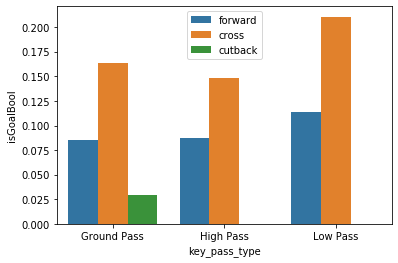

In [41]:
filt = df['cross_cutback_forward']=='none'
sns.barplot(x='key_pass_type',y='isGoalBool',hue='cross_cutback_forward',ci=None,data=df[~filt])
plt.legend(loc='upper center');

From the above analysis we can draw the following conclusions:
1. Crosses are more likely to create high xG shots followed by passes in the forward direction
2. The highest xG shots are created by low crosses.
3. In general low passes have a higher xG whether they are in the forward direction or across the field of play
4. Cutbacks are not very common in this dataset. Of the 42 cutbacks in the dataset, only 1 resultant shot was a goal

Next, let's analyze the pattern of play from which the key passes originated

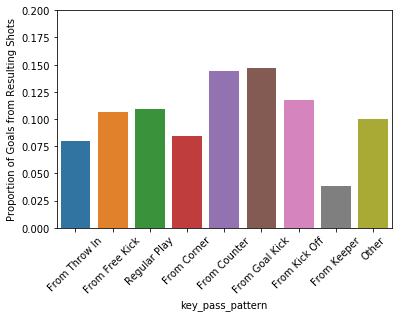

In [43]:
sns.barplot(x='key_pass_pattern',y='isGoalBool',ci=None,data=df[~filt])
plt.xticks(rotation=45)
plt.ylabel('Proportion of Goals from Resulting Shots');
plt.ylim([0,0.2]);

From the above it seems that the best key passes result from goal kicks, counters and kick offs.

As far as set pieces are considered, even though we saw earlier that free kicks are harder to score directly from, they often result in the best key passes, followed by corners and throw ins.

Next let's analyze if a shot being the end result of a carry helps it's chances of being a goal. To do this we will utilize the first_time feature. If a shot is taken first time it means the player shoots the ball without controlling it. By definition a first time shot cannot be the end result of the shooter's carry. 

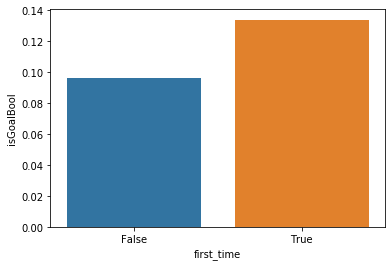

In [52]:
sns.barplot(x='first_time',y='isGoalBool',ci=None,data=df);

It appears first time shots are more likely to be successful than shots which are controlled

We've already seen from the above analysis that shot location is very important in shot conversion. Let's do a box-plot to quantify how important it is

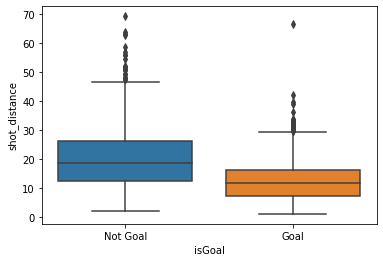

In [45]:
sns.boxplot(x='isGoal',y='shot_distance',data=df);

Most successful shots are taken within 20 yards from goal i.e the penalty area. Non successful shots are taken from farther away i.e there is an inverse relationship with shot conversion

Let's look at shot angle next

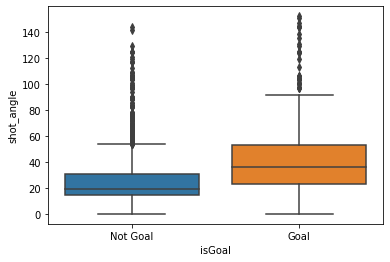

In [47]:
sns.boxplot(x='isGoal',y='shot_angle',data=df);

A lower angle corresponds to a longer distance away from the goal. Since we have established that shots taken from longer distances are less likely to score, it is not surprising to see that smaller shot angles result in fewer goals. Conversely, shots with a bigger shot angle are more likely to be goals

Now let's look at the type of shots as in open play vs freekicks and penalties

In [48]:
open_play_pct = quant_pct(df,'type_name','Open Play')
freekick_pct = quant_pct(df,'type_name','Free Kick')
penalty_pct = quant_pct(df,'type_name','Penalty')

print('The percentage of shots from open play which are goals is {0}'.format(round(open_play_pct,2)*100))
print('The percentage of shots from freekicks which are goals is {0}'.format(round(freekick_pct,2)*100))
print('The percentage of shots from penalties which are goals is {0}'.format(round(penalty_pct,2)*100))

The percentage of shots from open play which are goals is 10.0
The percentage of shots from freekicks which are goals is 6.0
The percentage of shots from penalties which are goals is 71.0


As shown above, penalties correspond to a very high probability of scoring while freekicks correspond to a very low probability of scoring. Open play shots generally easier to score than freekicks

Next, let's look at the packing density of opposition in front of the shot

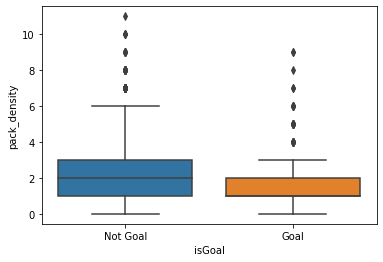

In [50]:
sns.boxplot(x='isGoal',y='pack_density',data=df);

Most shots, regardless of whether they were goals, are taken when fewer players are directly in between the shot and goal. Unsuccessful shots generally have more players in between the shot and the goal than successful shots. 

Packing density accounts for whether the goalkeeper is in the way of a shot. It doesn't qualitatively differentiate how good their positioning is. This is hard to quantify as it depends on the physical attributes for each keeper like jumping or diving reach, height etc. For this study, a simplistic approach will be adopted wherein packing density is the only metric which considers positioning of other players with respect to the shot

Finally let's analyze non type of play factors

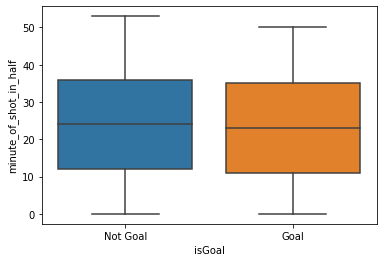

In [53]:
df['minute_of_shot_in_half']=df['timestamp'].dt.minute
sns.boxplot(x='isGoal',y='minute_of_shot_in_half',data=df);

We can see that the actual time of the shot is insignificant as to whether the shot is successful

Next, let's check if the shooter plays for the home or away team affect shot conversion

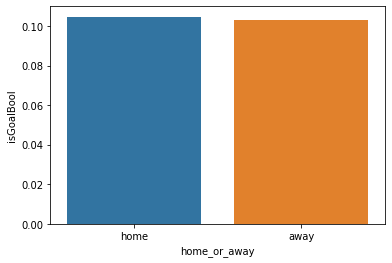

In [54]:
sns.barplot(x='home_or_away',y='isGoalBool',ci=None,data=df);

Whether the shooter is playing home or away also doesn't affect shot conversion